# Part 3 - Segmentation

In [92]:
import math
from os import listdir, makedirs, path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image, ImageDraw, ImageFont
from torchvision.io import decode_image
from torchvision.models import segmentation
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

dataset_root = "images"
output_dir = path.join("output", "part-3")
makedirs(output_dir, exist_ok=True)

model = None

GPU is available


### Setup and shared functions

In [ ]:
weights = segmentation.FCN_ResNet50_Weights.DEFAULT
preprocessor = weights.transforms()


def make_model():
    return segmentation.fcn_resnet50(weights=weights).to(device)


def load_dataset():
    images: list[tuple[str, torch.Tensor]] = [
        (path.splitext(f)[0], decode_image(path.join(dataset_root, f),
                                           mode=torchvision.io.ImageReadMode.RGB))
        for f in sorted(listdir(dataset_root))
        if f.endswith(".jpg") or f.endswith(".png")
    ]

    return images


ImageLike = torch.Tensor | np.ndarray | Image.Image


def show(imgs: ImageLike | list[ImageLike], max_cols=2):
    """
    Show an image or list of images

    Adapted from https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
    """
    if not isinstance(imgs, list):
        imgs = [imgs]

    ncols = min(len(imgs), max_cols)
    nrows = math.ceil(len(imgs) / ncols)
    _, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img.detach())

        if isinstance(img, Image.Image):
            img = np.asarray(img)

        axs[i // ncols, i % ncols].imshow(img)
        axs[i // ncols, i %
            ncols].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def save_image(img: ImageLike, file_basename: str):
    if isinstance(img, torch.Tensor):
        out: Image.Image = to_pil_image(img.detach())
    elif isinstance(img, np.ndarray):
        out: Image.Image = Image.fromarray(img)
    else:
        out = img

    out.save(path.join(output_dir, file_basename + ".png"))

#### Segmentation Color Palette

In [94]:
# autopep8: off
VOC_PALETTE = np.array([
    [0  , 0  , 0  ],  # 0 background
    [128, 0  , 0  ],  # 1 aeroplane
    [0  , 128, 0  ],  # 2 bicycle
    [128, 128, 0  ],  # 3 bird
    [0  , 0  , 128],  # 4 boat
    [128, 0  , 128],  # 5 bottle
    [0  , 128, 128],  # 6 bus
    [128, 128, 128],  # 7 car
    [64 , 0  , 0  ],  # 8 cat
    [192, 0  , 0  ],  # 9 chair
    [64 , 128, 0  ],  # 10 cow
    [192, 128, 0  ],  # 11 dining-table
    [64 , 0  , 128],  # 12 dog
    [192, 0  , 128],  # 13 horse
    [64 , 128, 128],  # 14 motorbike
    [192, 128, 128],  # 15 person
    [0  , 64 , 0  ],  # 16 potted-plant
    [128, 64 , 0  ],  # 17 sheep
    [0  , 192, 0  ],  # 18 sofa
    [128, 192, 0  ],  # 19 train
    [0  , 64 , 128],  # 20 tv/monitor
], dtype=np.uint8)
# autopep8: on

VOC_LABELS = np.array([
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "dining-table", "dog", "horse", "motorbike", "person",
    "potted-plant", "sheep", "sofa", "train", "tv/monitor"
], dtype=str)


def voc_legend(
        palette=VOC_PALETTE,
        labels=VOC_LABELS,
        patchsize=28,       # pixel size of the colour chip
        gap=6,              # gap between chips and text
        pad=6,              # outer padding
        cols=2,             # chips per row
        font_size=15
):
    """
    Helper function to show a legend for segmentation detections
    """
    rows = math.ceil(len(labels)/cols)

    # make it nice if possible
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # rough text width (all labels), for canvas size
    max_text_w = max(font.getlength(lbl) for lbl in labels) + gap
    w = pad*2 + cols*(patchsize + gap + max_text_w)
    h = pad*2 + rows*patchsize

    img = Image.new("RGB", (int(w), int(h)), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    for idx, (rgb, lbl) in enumerate(zip(palette, labels)):
        r, c = divmod(idx, cols)
        x0 = pad + c*(patchsize + gap + max_text_w)
        y0 = pad + r*patchsize
        # coloured square
        draw.rectangle([x0, y0, x0+patchsize, y0+patchsize],
                       fill=tuple(int(v) for v in rgb))
        # text baseline is vertically centred inside the square
        tx = x0 + patchsize + gap
        ty = y0 + (patchsize - font_size)//2
        draw.text((tx, ty), lbl, fill=(0, 0, 0), font=font)

    return img

### Segmentation

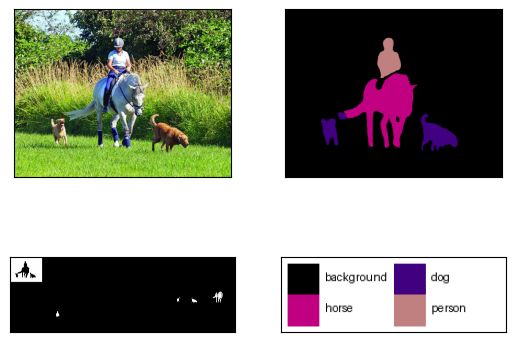

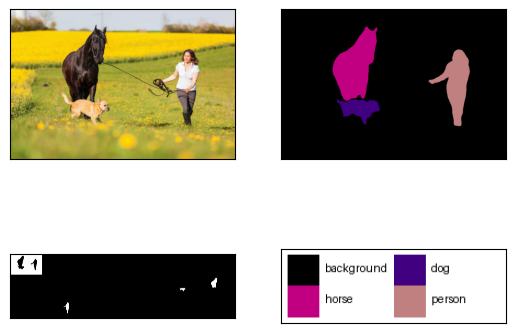

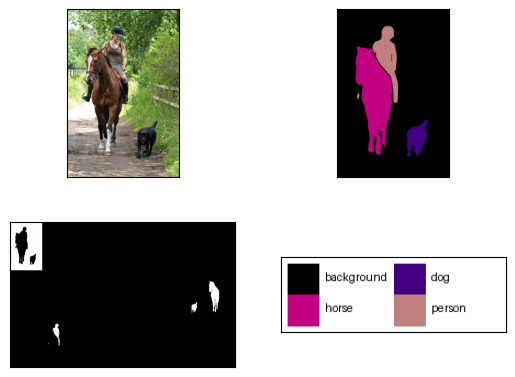

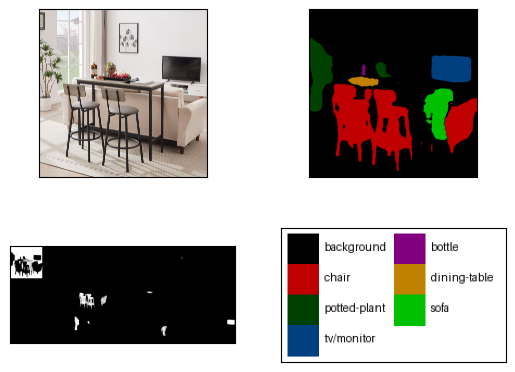

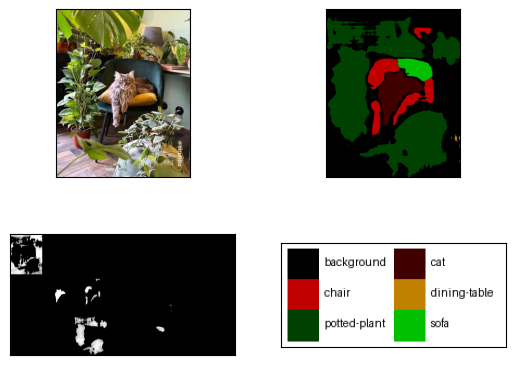

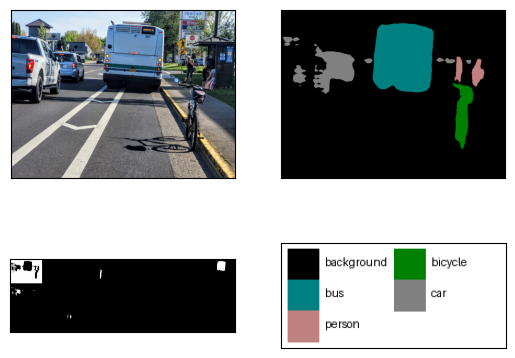

In [95]:
# setup the model in eval mode
model = make_model().eval()
dataset = load_dataset()

# basic threshold to limit noise (shouldn't be too high)
threshold = 0.5

for name, image in dataset:
    # add an extra dimension because torch said so
    preprocessed = preprocessor(image).unsqueeze(0).to(device)
    output: torch.Tensor = model(preprocessed)["out"][0]

    # convert to probabilities
    normalized_masks = torch.nn.functional.softmax(output, dim=0)
    normalized_masks[normalized_masks < threshold] = 0

    # create the feature map grid (grayscale)
    feature_map = make_grid(normalized_masks.unsqueeze(1),
                            nrow=7, padding=2, normalize=True, scale_each=True)

    # get a map of the most probable class
    segmented = normalized_masks.cpu().argmax(dim=0)
    # convert to RGB based off the palette
    seg_image = VOC_PALETTE[segmented]
    
    # create a legend for the detected classes
    detections = np.unique(segmented)
    legend = voc_legend(VOC_PALETTE[detections],
                        VOC_LABELS[detections])

    save_image(seg_image, f"{name}-segmented")
    save_image(feature_map, f"{name}-feature-map")

    show([image,
          seg_image,
          feature_map,
          legend])